# Picky Lag-CRP
A modification of the lag-CRP that allows the analyst to be picky about the recall transitions they're interested in. Pass a boolean array `include` argument of same size as your `trials` argument. Only recalls at indices where the `include` is True will be considered in the analysis. 

Picky Lag-CRP also allows the analyst to specify a desired "reference serial position" for computation of serial lags when that differs from the index encoded into the `trials` argument. Pass a 1-indexed array argument `reference` of same size as item_count. Wherever the value `i` occurs in `trials`, the value at position `i-1` in `reference` in the matching row will be used as the reference serial position. 

We assume your `trials` array represents recalls with 1-index values and non-recall with the value 0.; your `reference` argument should similarly be 1-index, with the value `1` indicating the first serial position in the study list. When the matched in `reference` is 0 or the value in `trials` is 0, transitions from the considered recall event will not be included in the analysis. `references` are only used instead of the value in `trials` when considering recall transitions from the referenced item.

*NOTE*: this function assumes you're performing a lag-CRP on a pure list where each unique item is presented just once. Lag-CRP analysis on lists with item repetitions is more complicated and implemented elsewhere.

## Function

In [231]:
import numpy as np

def picky_lag_crp(trials, item_count, include=None, reference=None):

    if include is None:
        include = np.ones(np.shape(trials), dtype=bool)

    if reference is None:
        reference = trials
    
    lag_range = item_count - 1
    total_actual_lags = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    terminus = np.sum(trials != 0, axis=1)
    
    # tabulate bin totals for actual and possible lags
    for i in range(len(trials)):
        possible_items = np.arange(item_count) + 1
        previous_item = 0
        
        for recall_index in range(terminus[i]):

            # track possible and actual lags, only processing transitions from included recall indices
            if (recall_index > 0) and (include[i, recall_index]) and (reference[i, recall_index-1] != 0):
                
                # track possible lags taking into account current item's reference value
                possible_lags = possible_items - reference[i, recall_index-1]
                possible_lags += lag_range
                total_possible_lags[possible_lags] += 1
                
                # pull actual lag from tracked possible lags
                current_index = np.nonzero(possible_items==trials[i, recall_index])[0]
                actual_lag = possible_lags[current_index]
                total_actual_lags[actual_lag] += 1
                
            # update pool of possible items to exclude recalled item
            previous_item = trials[i, recall_index]
            possible_items = possible_items[possible_items != previous_item]
    
    # small correction to avoid nans
    total_possible_lags[total_actual_lags==0] += 1
    
    return total_actual_lags/total_possible_lags

## Demo
We demo this extra functionality with a comparative lag-CRP analysis suggested by Sean last Wednesday or something. What's the structure of the lag-contiguity effect when the lag between the last recalled item and the second-to-last recalled item is high? 

To find out, we will use use picky_lag_crp's `include` argument to focus our lag-CRP analysis on transitions from pairs of recalls with high serial lag from one another. We'll run this analysis twice -- once with `reference` set to the serial position of the last recall, and once with `reference` set to the serial position of the second-to-last recall. We'll align these two CRPs in one plot. 

For comparison, we'll also create this plot with the `include` argument focusing the analysis on transitions from pairs of recalls with low serial lag from one another.

In [253]:
from compmemlearn.datasets import prepare_murdock1970_data

trials, events, list_length = prepare_murdock1970_data('data/mo1970.txt')
events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


### Computing `Include` and `Reference`
For entries in `include`, we'll find all recalls whose prior two recalls are above (or below) a lag threshold from their previous recall. 

For entries in `reference`, we'll use the serial position of the last recalled item. This way, we can compute a CRP relative to the i-2 recall position in addition to the i-1 recall position.

In [265]:
lag_threshold = 6

prior_transition_lags = trials[:, 1:] - trials[:, :-1]
prior_transition_lags = np.pad(prior_transition_lags, ((0, 0), (2, 0)), "constant", constant_values=0)
prior_transition_lags = prior_transition_lags[:, :-1]

above_threshold = np.logical_and(
    np.logical_and(np.abs(prior_transition_lags) > lag_threshold, trials != 0), 
    prior_transition_lags != 0,
)
below_threshold = np.logical_and(
    np.logical_and(np.abs(prior_transition_lags) < lag_threshold, trials != 0),
    prior_transition_lags != 0,
)

In [266]:
# generate reference that shifts trials array one column right
reference = np.pad(trials, ((0,0),(1,0)), 'constant', constant_values=0)

# delete last column of reference
reference = reference[:, :-1]

### Above-Threshold Result

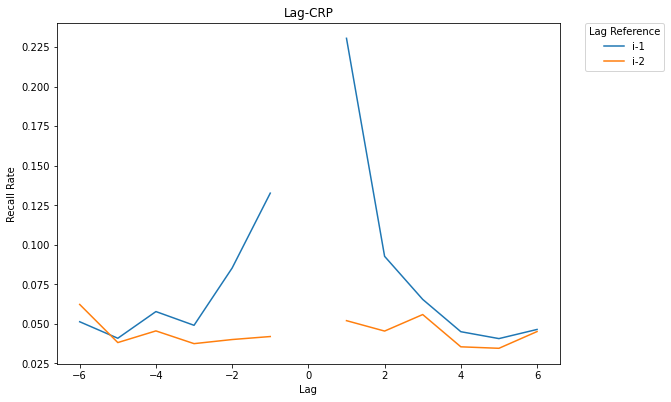

In [267]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

base = picky_lag_crp(trials, list_length, above_threshold)
base[list_length-1] = np.nan

minus_one = picky_lag_crp(trials, list_length, above_threshold, reference)
minus_one[list_length-1] = np.nan

max_lag = lag_threshold
base = pd.DataFrame(
        {'Lag': np.arange(max_lag*2 + 1, dtype=int)-max_lag, 'Recall Rate': base[list_length-max_lag-1:list_length+max_lag], 'Reference': 'i-1'})
minus_one = pd.DataFrame(
        {'Lag': np.arange(max_lag*2 + 1, dtype=int)-max_lag, 'Recall Rate': minus_one[list_length-max_lag-1:list_length+max_lag], 'Reference': 'i-2'})

# concatenate dataframes
crp = pd.concat([base, minus_one]).reset_index()

# plot result
plt.figure(figsize=(10, 6))
filt_neg = f'{-max_lag} <= Lag < 0'
filt_pos = f'0 < Lag <= {max_lag}'

sns.lineplot(data=crp.query(filt_neg), x='Lag', y='Recall Rate', hue='Reference', ci=None, legend=False)
sns.lineplot( data=crp.query(filt_pos), x='Lag', y='Recall Rate', hue='Reference', ci=None, legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Lag Reference')

plt.tight_layout(pad=3)
plt.title('Lag-CRP');

### Below-Threshold Result

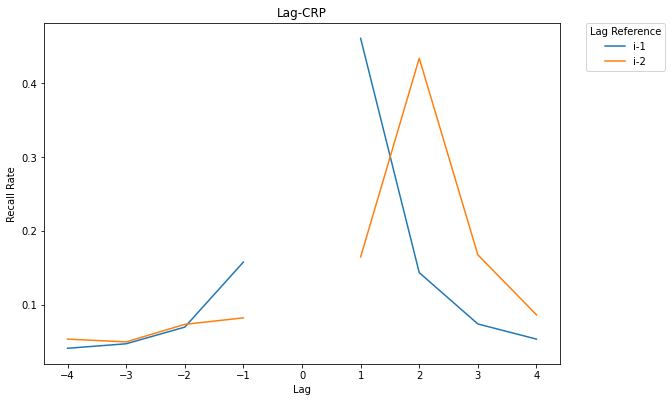

In [258]:
base = picky_lag_crp(trials, list_length, below_threshold)
base[list_length-1] = np.nan

minus_one = picky_lag_crp(trials, list_length, below_threshold, reference)
minus_one[list_length-1] = np.nan

max_lag = lag_threshold
base = pd.DataFrame(
        {'Lag': np.arange(max_lag*2 + 1, dtype=int)-max_lag, 'Recall Rate': base[list_length-max_lag-1:list_length+max_lag], 'Reference': 'i-1'})
minus_one = pd.DataFrame(
        {'Lag': np.arange(max_lag*2 + 1, dtype=int)-max_lag, 'Recall Rate': minus_one[list_length-max_lag-1:list_length+max_lag], 'Reference': 'i-2'})

# concatenate dataframes
crp = pd.concat([base, minus_one]).reset_index()

# plot result
plt.figure(figsize=(10, 6))
filt_neg = f'{-max_lag} <= Lag < 0'
filt_pos = f'0 < Lag <= {max_lag}'

sns.lineplot(data=crp.query(filt_neg), x='Lag', y='Recall Rate', hue='Reference', ci=None, legend=False)
sns.lineplot( data=crp.query(filt_pos), x='Lag', y='Recall Rate', hue='Reference', ci=None, legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Lag Reference')

plt.tight_layout(pad=3)
plt.title('Lag-CRP');

### Comparing Above Threshold i-1 CRP and Below Threshold i-1 CRP
This should more cleanly reproduce Lynn's main result -- when the i-2 recall is of a low lag from the i-1 recall, another low-lag transition is especially likely.

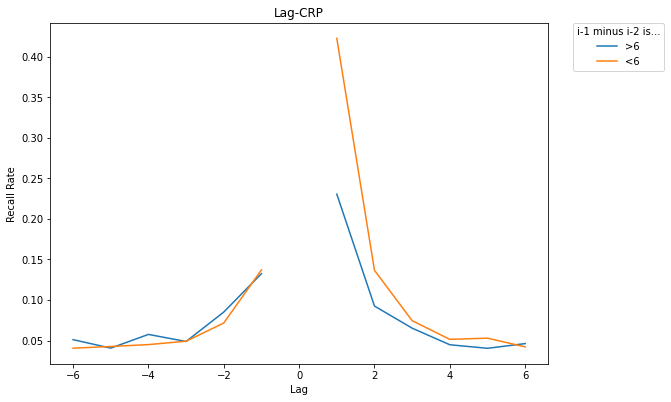

In [268]:
above = picky_lag_crp(trials, list_length, above_threshold)
above[list_length-1] = np.nan

below = picky_lag_crp(trials, list_length, below_threshold)
below[list_length-1] = np.nan

max_lag = lag_threshold
above = pd.DataFrame(
        {'Lag': np.arange(max_lag*2 + 1, dtype=int)-max_lag, 'Recall Rate': above[list_length-max_lag-1:list_length+max_lag], 'Threshold': '>'+str(lag_threshold)})
below = pd.DataFrame(
        {'Lag': np.arange(max_lag*2 + 1, dtype=int)-max_lag, 'Recall Rate': below[list_length-max_lag-1:list_length+max_lag], 'Threshold': '<'+str(lag_threshold)})

# concatenate dataframes
crp = pd.concat([above, below]).reset_index()

# plot result
plt.figure(figsize=(10, 6))
filt_neg = f'{-max_lag} <= Lag < 0'
filt_pos = f'0 < Lag <= {max_lag}'

sns.lineplot(data=crp.query(filt_neg), x='Lag', y='Recall Rate', hue='Threshold', ci=None, legend=False)
sns.lineplot( data=crp.query(filt_pos), x='Lag', y='Recall Rate', hue='Threshold', ci=None, legend=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='i-1 minus i-2 is...')

plt.tight_layout(pad=3)
plt.title('Lag-CRP');

## Discussion

This code would need further extension to support a repetition contiguity analysis, but it demonstrates how to apply a "masked" lag-CRP analysis where conditional response probabilities are only calculated over a selection of recall transitions. Similar analyses might mask recalls by serial position, semantic similarity, or other criteria. I'm less impressed with the lag-reference functionality demoed here, but it's also necessary for some analyses, including my repetition contiguity analysis.

This particular example reveals a potential limitation of this approach, though: since lag-CRPs depend on prior recall history as well as the last recalled item, measured differences in lag-contiguity between subsets of recall events might not be because of the subsetting but rather because of other conditions. Care must be taken to rule alternative explanations like these.

This reminds me of my repetition contiguity analysis. Could my effect be explicable in terms of prior recall events before retrieval of repeated items? If so, it would be odd that CMR doesn't account for the effect. If I wanted to, I could clarify this with a reverse analysis where at each recall of a repeatedly-presented item, I track the serial lag of the item recalled immediately beforehand.